In [2]:
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets.mnist
from torchvision import transforms
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [5]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2049
    length = get_int(data[4:8])
    parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
    return torch.from_numpy(parsed).view(length).long()

In [6]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
    assert get_int(data[:4]) == 2051
    length = get_int(data[4:8])
    num_rows = get_int(data[8:12])
    num_cols = get_int(data[12:16])
    images = []
    parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
    return torch.from_numpy(parsed).view(length, num_rows, num_cols)

In [7]:
class MNISTPairs(torch.utils.data.Dataset):
    raw_folder = 'MNIST/raw'
    processed_folder = 'MNIST/processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train # training set or test set

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))

            train_labels_class = []
            train_data_class = []
            for i in range(10):
                indices = torch.squeeze((self.train_labels == i).nonzero())
                train_labels_class.append(torch.index_select(self.train_labels, 0, indices))
                train_data_class.append(torch.index_select(self.train_data, 0, indices))

            # generate balanced pairs
            self.train_data = []
            self.train_labels = []
            lengths = [x.shape[0] for x in train_labels_class]
            for i in range(10):
                for j in range(500): # create 500 pairs
                    rnd_cls = random.randint(0,8) # choose random class that is not the same class
                    if rnd_cls >= i:
                        rnd_cls = rnd_cls + 1

                    rnd_dist = random.randint(0, 100)

                    self.train_data.append(torch.stack([train_data_class[i][j], train_data_class[i][j+rnd_dist], train_data_class[rnd_cls][j]]))
                    self.train_labels.append([1,0])

            self.train_data = torch.stack(self.train_data)
            self.train_labels = torch.tensor(self.train_labels)

        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

            test_labels_class = []
            test_data_class = []
            for i in range(10):
                indices = torch.squeeze((self.test_labels == i).nonzero())
                test_labels_class.append(torch.index_select(self.test_labels, 0, indices))
                test_data_class.append(torch.index_select(self.test_data, 0, indices))

            # generate balanced pairs
            self.test_data = []
            self.test_labels = []
            lengths = [x.shape[0] for x in test_labels_class]
            for i in range(10):
                for j in range(500): # create 500 pairs
                    rnd_cls = random.randint(0,8) # choose random class that is not the same class
                    if rnd_cls >= i:
                        rnd_cls = rnd_cls + 1

                    rnd_dist = random.randint(0, 100)

                    self.test_data.append(torch.stack([test_data_class[i][j], test_data_class[i][j+rnd_dist], test_data_class[rnd_cls][j]]))
                    self.test_labels.append([1,0])

            self.test_data = torch.stack(self.test_data)
            self.test_labels = torch.tensor(self.test_labels)

    def __getitem__(self, index):
        if self.train:
            imgs, target = self.train_data[index], self.train_labels[index]
        else:
            imgs, target = self.test_data[index], self.test_labels[index]

        img_ar = []
        for i in range(len(imgs)):
            img = Image.fromarray(imgs[i].numpy(), mode='L')
            if self.transform is not None:
                img = self.transform(img)
            img_ar.append(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img_ar, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.linear1 = nn.Linear(2304, 512)

        self.linear2 = nn.Linear(512, 2)
    def get_embedding(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = F.relu(x)
        return x
    def forward_from_embedding(self, emb1, emb2):
        res = torch.abs(emb2 - emb1)
        res = self.linear2(res)
        return res

    def forward(self, data):
        res = []
        for i in range(2): # Siamese nets; sharing weights
            x = data[i]
            x = self.conv1(x)
            x = F.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.conv3(x)
            x = F.relu(x)

            x = x.view(x.shape[0], -1)
            x = self.linear1(x)
            res.append(F.relu(x))

        res = torch.abs(res[1] - res[0])
        res = self.linear2(res)
        return res
   

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward_dist_label(self, dist, label):
        loss = torch.mean(1/2*(label) * torch.pow(dist, 2) +
                                      1/2*(1-label) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2))


        return loss
    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):
        dist1 = F.pairwise_distance(anchor,positive)
#         dist1 = (anchor - positive).pow(2).sum(1)
        label1 = t_p
        
        dist2 = F.pairwise_distance(anchor,negative)
#         dist2 = (anchor - negative).pow(2).sum(1)
        label2 = t_n
        
        loss = self.forward_dist_label(dist1,label1) + self.forward_dist_label(dist2,label2)
        return loss

In [11]:
class TripletLoss(torch.nn.Module):
    """
    Triplet loss function.
    """

    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):

#         squarred_distance_1 = torch.norm(anchor-positive,dim=1)
        
#         squarred_distance_2 = torch.norm(anchor-negative,dim=1)

        squarred_distance_1 = (anchor - positive).pow(2).sum(1)
        
        squarred_distance_2 = (anchor - negative).pow(2).sum(1)
        
        triplet_loss = F.relu( self.margin + squarred_distance_1 - squarred_distance_2 ).mean()
        
        return triplet_loss

In [12]:
class CrossEntLoss(torch.nn.Module):
    """
    Cross Entropy loss function.
    """

    def __init__(self):
        super(CrossEntLoss, self).__init__()

    def forward(self, anchor, positive, negative, op_p, op_n, t_p, t_n):

        loss_positive = F.cross_entropy(op_p, t_p)
        loss_negative = F.cross_entropy(op_n, t_n)
        loss = loss_positive + loss_negative
        
        return loss

In [22]:
def cross_ent_fn(anchor, positive, negative, op_p, op_n, t_p, t_n):

    loss_positive = F.cross_entropy(op_p, t_p)
    loss_negative = F.cross_entropy(op_n, t_n)
    loss = loss_positive + loss_negative

    return loss

In [14]:
def train(model, device, train_loader, epoch, optimizer, loss_fn):
    model.train()
    curr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        
        optimizer.zero_grad()
        embedding_anchor = model.get_embedding(data[0])
        embedding_positive = model.get_embedding(data[1])
        embedding_negative = model.get_embedding(data[2])
        
        output_positive = model.forward_from_embedding(embedding_anchor, embedding_positive)
        output_negative = model.forward_from_embedding(embedding_anchor, embedding_negative)
#         output_positive = model([data[0], data[1]])
#         output_negative = model([data[0], data[2]])

        target = target.type(torch.LongTensor).to(device)
        target_positive = torch.squeeze(target[:,0])
        target_negative = torch.squeeze(target[:,1])

#         loss_positive = F.cross_entropy(output_positive, target_positive)
#         loss_negative = F.cross_entropy(output_negative, target_negative)
#         loss = loss_positive + loss_negative
        
        loss = loss_fn(embedding_anchor,embedding_positive,embedding_negative,
                       output_positive,output_negative, target_positive, target_negative)

        loss.backward()
        
        optimizer.step()
        
        curr_loss += loss.item()
        
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1)*batch_size, len(train_loader.dataset), 100. * (batch_idx+1)*batch_size / len(train_loader.dataset),
                curr_loss*1.0/((batch_idx+1)*batch_size)),end='\t\t\t')
    print('')

In [15]:
def test(model, device, test_loader, loss_fn):
    model.eval()

    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            
            embedding_anchor = model.get_embedding(data[0])
            embedding_positive = model.get_embedding(data[1])
            embedding_negative = model.get_embedding(data[2])

            output_positive = model.forward_from_embedding(embedding_anchor, embedding_positive)
            output_negative = model.forward_from_embedding(embedding_anchor, embedding_negative)
#             output_positive = model([data[0], data[1]])
#             output_negative = model([data[0], data[2]])

            target = target.type(torch.LongTensor).to(device)
            target_positive = torch.squeeze(target[:,0])
            target_negative = torch.squeeze(target[:,1])

#             loss_positive = F.cross_entropy(output_positive, target_positive)
#             loss_negative = F.cross_entropy(output_negative, target_negative)

#             loss += loss_positive + loss_negative

            loss += loss_fn(embedding_anchor,embedding_positive,embedding_negative,
                           output_positive, output_negative, target_positive, target_negative)
    
            accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
            accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()

            accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
            all_labels = all_labels + len(target_positive) + len(target_negative)

        accuracy = 100. * accurate_labels / all_labels
        print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss/all_labels))
   

In [16]:
def oneshot(model, device, data):
    model.eval()

    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
#         out1 = model.get_embedding(data[0])
#         out2 = model.get_embedding(data[1])
        output = model([data[0],data[1]])
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

In [17]:
batch_size = 20


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [19]:
train_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=True, transform=trans), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=False, transform=trans), batch_size=batch_size, shuffle=False)

### Contrastive Loss

In [27]:
# embedding_net = EmbeddingNet().to(device)
model = Net().to(device)

lr = 0.0001
num_epochs = 10
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = ContrastiveLoss()
for epoch in range(num_epochs):
    train(model, device, train_loader, epoch, optimizer,loss_fn)
    test(model, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.023851			
Test accuracy: 5403/10000 (54.030%)	Loss: 0.009951
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.013879			
Test accuracy: 5871/10000 (58.710%)	Loss: 0.007793
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.009920			
Test accuracy: 6195/10000 (61.950%)	Loss: 0.006723
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.007487			
Test accuracy: 6532/10000 (65.320%)	Loss: 0.005756
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.005784			
Test accuracy: 6285/10000 (62.850%)	Loss: 0.005183
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.004522			
Test accuracy: 6494/10000 (64.940%)	Loss: 0.004627
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.003582			
Test accuracy: 6431/10000 (64.310%)	Loss: 0.004658
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.002922			
Test accuracy: 6680/10000 (66.800%)	Loss: 0.004236
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.002331			
Test accuracy: 6803/10000 (68.030%)	Loss: 0.003895
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.001929			
Test accuracy: 6639/1

In [ ]:
# embedding_net = EmbeddingNet().to(device)
model = Net().to(device)

lr = 0.0001
num_epochs = 10
weight_decay = 1e-6

optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = ContrastiveLoss()
for epoch in range(num_epochs):
    train(model, device, train_loader, epoch, optimizer,loss_fn)
    test(model, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.022625			
Test accuracy: 5571/10000 (55.710%)	Loss: 0.009709
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.013143			
Test accuracy: 5803/10000 (58.030%)	Loss: 0.007532
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.009271			
Test accuracy: 5962/10000 (59.620%)	Loss: 0.006065
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.006943			
Test accuracy: 6065/10000 (60.650%)	Loss: 0.005159
Train Epoch: 4 [1900/5000 (38%)]	Loss: 0.005452			

### Triplet Loss

In [24]:
# embedding_net = EmbeddingNet().to(device)
model = Net().to(device)

lr = 0.001
num_epochs = 20
weight_decay = 1e-6

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = TripletLoss()
for epoch in range(num_epochs):
    train(model, device, train_loader, epoch, optimizer,loss_fn)
    test(model, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.030538			
Test accuracy: 5000/10000 (50.000%)	Loss: 0.014370
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.014318			
Test accuracy: 4995/10000 (49.950%)	Loss: 0.007102
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.009528			
Test accuracy: 4999/10000 (49.990%)	Loss: 0.008487
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.007578			
Test accuracy: 4991/10000 (49.910%)	Loss: 0.007084
Train Epoch: 4 [4920/5000 (98%)]	Loss: 0.005604			

KeyboardInterrupt: 

### Cross Entropy Loss

In [38]:
# embedding_net = EmbeddingNet().to(device)
model = Net().to(device)

lr = 0.001
num_epochs = 10
weight_decay = 0.0001

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = CrossEntLoss()
for epoch in range(num_epochs):
    train(model, device, train_loader, epoch, optimizer,loss_fn)
    test(model, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.047354			
Test accuracy: 8460/10000 (84.600%)	Loss: 0.018568
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.024589			
Test accuracy: 9023/10000 (90.230%)	Loss: 0.013119
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.014913			
Test accuracy: 9253/10000 (92.530%)	Loss: 0.010105
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.008847			
Test accuracy: 9313/10000 (93.130%)	Loss: 0.010797
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.006702			
Test accuracy: 9408/10000 (94.080%)	Loss: 0.009446
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.004167			
Test accuracy: 9523/10000 (95.230%)	Loss: 0.009084
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.003367			
Test accuracy: 9396/10000 (93.960%)	Loss: 0.010587


KeyboardInterrupt: 

In [23]:
# embedding_net = EmbeddingNet().to(device)
model = Net().to(device)

lr = 0.001
num_epochs = 10
weight_decay = 0.0001

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = CrossEntLoss()
for epoch in range(num_epochs):
    train(model, device, train_loader, epoch, optimizer,cross_ent_fn)
    test(model, device, test_loader,loss_fn)

Train Epoch: 0 [5000/5000 (100%)]	Loss: 0.043046			
Test accuracy: 8555/10000 (85.550%)	Loss: 0.016992
Train Epoch: 1 [5000/5000 (100%)]	Loss: 0.020080			
Test accuracy: 9216/10000 (92.160%)	Loss: 0.010167
Train Epoch: 2 [5000/5000 (100%)]	Loss: 0.011011			
Test accuracy: 9393/10000 (93.930%)	Loss: 0.008361
Train Epoch: 3 [5000/5000 (100%)]	Loss: 0.008037			
Test accuracy: 9320/10000 (93.200%)	Loss: 0.010488
Train Epoch: 4 [5000/5000 (100%)]	Loss: 0.005362			
Test accuracy: 9385/10000 (93.850%)	Loss: 0.009253
Train Epoch: 5 [5000/5000 (100%)]	Loss: 0.004921			
Test accuracy: 9447/10000 (94.470%)	Loss: 0.007939
Train Epoch: 6 [5000/5000 (100%)]	Loss: 0.003130			
Test accuracy: 9419/10000 (94.190%)	Loss: 0.010704
Train Epoch: 7 [5000/5000 (100%)]	Loss: 0.002753			
Test accuracy: 9481/10000 (94.810%)	Loss: 0.009561
Train Epoch: 8 [5000/5000 (100%)]	Loss: 0.003303			
Test accuracy: 9593/10000 (95.930%)	Loss: 0.007648
Train Epoch: 9 [5000/5000 (100%)]	Loss: 0.002360			
Test accuracy: 9347/1

### Sample

In [41]:
from matplotlib import pyplot as plt

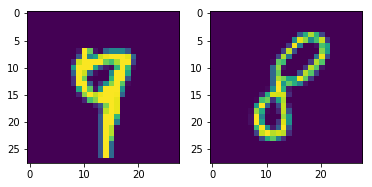

These two images are not of the same number


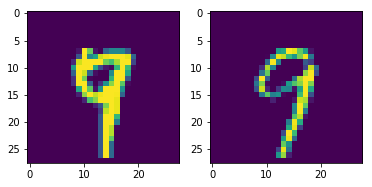

These two images are of the same number


In [43]:
prediction_loader = torch.utils.data.DataLoader(MNISTPairs('~/.pytorch/MNIST/', train=False, transform=trans), batch_size=1, shuffle=True)

triplets = next(iter(prediction_loader))

data = []
data.extend(triplets[0][:3:2])
fig, axes = plt.subplots(1,2)
axes[0].imshow(data[0].numpy()[0,0])
axes[1].imshow(data[1].numpy()[0,0])
plt.show()
same = oneshot(model, device, data)
if same > 0:
    print('These two images are of the same number')
else:
    print('These two images are not of the same number')
    
data = []
data.extend(triplets[0][:2])
fig, axes = plt.subplots(1,2)
axes[0].imshow(data[0].numpy()[0,0])
axes[1].imshow(data[1].numpy()[0,0])
plt.show()
same = oneshot(model, device, data)
if same > 0:
    print('These two images are of the same number')
else:
    print('These two images are not of the same number')